In [39]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import histopathology as hcd # Helper code stored as Kaggle Script

In [2]:
DATASET_PATH = '/kaggle/input/histopathologic-cancer-detection'

In [3]:
# Train/validation split distribution
train_pct = 80
# Training parameters
batch_size = 50
# For mean normalization. Computed over the dataset.
rgb_means = [0.7024860505690291, 0.5462877872713974, 0.6964813026563755]
rgb_stds = [0.23890759190102304, 0.28214205984973445, 0.21625778862043862]

In [7]:
train_dir = os.path.join(DATASET_PATH, 'train')
train_labels = os.path.join(DATASET_PATH, 'train_labels.csv')
pcam_dataset = hcd.dataset.PCam(train_dir, train_labels,
                                transforms.Compose([
                                    transforms.CenterCrop(48),
                                    transforms.ToTensor(),
                                    hcd.transforms.ToNormalized(rgb_means, rgb_stds),
                                ]))
print(f'PCam train set has {len(pcam_dataset)} samples')

PCam train set has 220025 samples


In [8]:
test_dir = os.path.join(DATASET_PATH, 'test')
test_set = hcd.dataset.UnlabeledPCam(test_dir, 
                                    transforms.Compose([
                                        transforms.CenterCrop(48),
                                        transforms.ToTensor(),
                                        hcd.transforms.ToNormalized(rgb_means, rgb_stds),
                                    ]))
print(f'PCam test set has {len(test_set)} samples')

PCam test set has 57458 samples


In [9]:
train_size = int(train_pct/100 * len(pcam_dataset))
val_size = len(pcam_dataset) - train_size
print(f'Splitting PCam train set {train_pct}%/{100-train_pct}% into train/validation sets')
# Seed PRNG with the answer to the Ultimate Question of Life, the Universe, and Everything
train_set, val_set = utils.data.random_split(pcam_dataset, 
                                             [train_size, val_size],
                                             generator=torch.Generator().manual_seed(42))

Splitting PCam train set 80%/20% into train/validation sets


In [10]:
train_loader = utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, shuffle=True)
val_loader   = utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader  = utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [12]:
veggie16 = hcd.models.Veggie16(pretrained=False, freeze_weights=False).to(device)
veggie16.load_state_dict(torch.load('../models/Veggie16_final.pth'))

<All keys matched successfully>

In [22]:
hcd.evaluation.predict_to_csv(veggie16, test_loader, device, test_set.image_paths, 
                              '../predictions/preds_veggie16.csv', batch_size=batch_size)

Computed predictions for sample [100/176]
Scoring Veggie16 on Train Set
------------------------------
AUC ROC: 0.9872


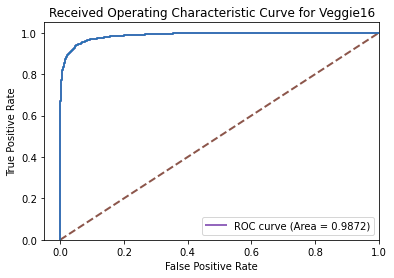

In [45]:
auc, fpr, tpr, thresholds = hcd.evaluation.roc(veggie16, train_loader, device, subsample=0.05)
print(f'Scoring {veggie16.__class__.__name__} on Train Set')
print('-'*30)
print(f'AUC ROC: {auc:.4f}')
hcd.evaluation.plot_roc(fpr, tpr, auc, veggie16.__class__.__name__)
plt.savefig('../figures/veggie16_base_train_roc.png')

Computed predictions for sample [100/176]
Scoring Veggie16 on Validation Set
------------------------------
AUC ROC: 0.9778


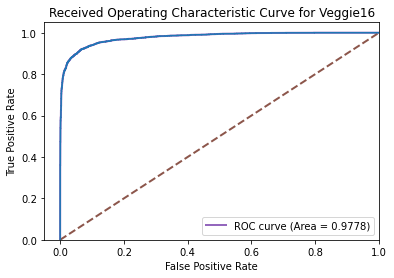

In [46]:
auc, fpr, tpr, thresholds = hcd.evaluation.roc(veggie16, val_loader, device, subsample=0.2)
print(f'Scoring {veggie16.__class__.__name__} on Validation Set')
print('-'*30)
print(f'AUC ROC: {auc:.4f}')
hcd.evaluation.plot_roc(fpr, tpr, auc, veggie16.__class__.__name__)
plt.savefig('../figures/working/veggie16_base_val_roc.png')

In [ ]:
raisinnet34 = hcd.models.RaisinNet34(pretrained=False, freeze_weights=False).to(device)
raisinnet34.load_state_dict(torch.load('../models/RaisinNet34_final.pth'))

In [ ]:
hcd.evaluation.predict_to_csv(raisinnet34, test_loader, device, test_set.image_paths, 
                              '../predictions/preds_raisinnet34.csv', batch_size=batch_size)

In [ ]:

auc, fpr, tpr, thresholds = hcd.evaluation.roc(raisinnet34, train_loader, device, subsample=0.05)
print(f'Scoring {raisinnet34.__class__.__name__} on Train Set')
print('-'*30)
print(f'AUC ROC: {auc:.4f}')
hcd.evaluation.plot_roc(fpr, tpr, auc, raisinnet34.__class__.__name__)
plt.savefig('../figures/raisinnet34_base_train_roc.png')

In [ ]:
auc, fpr, tpr, thresholds = roc(raisinnet34, val_loader, device, subsample=0.2)
print(f'Scoring {raisinnet34.__class__.__name__} on Validation Set')
print('-'*30)
print(f'AUC ROC: {auc:.4f}')
hcd.evaluation.plot_roc(fpr, tpr, auc, raisinnet34.__class__.__name__)
plt.savefig('../figures/raisinnet34_base_val_roc.png')